# * Business Growth Overview *

## Note :

### Compare with VINSIGHT overview : 
- Total Revenue data about 2 days late.
- Target is lower than VINSIGHT (include "TDG" ?)
- %MoM, %WoW is different from VINSIGHT

## Import Data Source
Monitoring Job : 9.00 / 14.00 / 18.00 / 22.00

In [105]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import configparser
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
# import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [106]:
''' Config '''

config = configparser.ConfigParser()
config.read('../my_config.ini')
config.sections()
as_week = config['PARAM']['as_week']

In [107]:
data_src = f"../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)

cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 
        'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'BASELINE_SNAP', 'BASELINE_AGG', 'PPN_TM']

df = df[cols]

''' Fix Metric CD list '''
prepaid_rev_cd_list = ['B1R000100', 'DB1R000100', 'TB1R000100']
postpaid_rev_cd_list = ['B2R000100', 'DB2R000100', 'TB2R000100']
tol_tvs_tdg_rev_cd_list = ['TB3R000100', 'TB4R000100'] 

bg_rev_all_cd_list = prepaid_rev_cd_list + postpaid_rev_cd_list + tol_tvs_tdg_rev_cd_list

''' Fix Agg Column Name(Total Revenue) '''
bg_col_list = ['POST_DTAC', 'POST_TMH', 'PRE_DTAC', 'PRE_TMH', 'TOL', 'TVS']

In [108]:
df.shape

(100408, 24)

In [109]:
df = df[df['METRIC_CD'].isin(bg_rev_all_cd_list)]#.reset_index()

In [110]:
df[['METRIC_CD', 'METRIC_NAME']].drop_duplicates()

,METRIC_CD,METRIC_NAME
47303,B2R000100,Postpaid Revenue
47518,DB2R000100,Postpaid Revenue : DTAC
47733,TB2R000100,Postpaid Revenue : TMH
64933,B1R000100,Prepaid Revenue
65148,DB1R000100,Prepaid Revenue : DTAC
65578,TB1R000100,Prepaid Revenue : TMH (Geo)
82563,TB3R000100,TOL Revenue (Geo)
94603,TB4R000100,TVS Revenue (Geo)


In [111]:
''' Find Metric '''

# df_metric = df.groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME']).size().reset_index()
df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]#.reset_index()
df_metric = pd.concat([df_agg_s, df_agg_n])
df_metric

# df_tmp = df_metric[df_metric['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")]#.reset_index()
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()
# df_tmp = df_tmp[df_tmp['PRODUCT_GRP']=="TVS"]

# # df_tmp.to_excel('Prepaid_Metric.xlsx')
# df_tmp

,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,METRIC_NAME,AGG_TYPE,ACTUAL_SNAP,TARGET_SNAP
0,Revenue,Revenue,ALL,Postpaid,B2R000100,Postpaid Revenue,S,4.534034e+10,4.624458e+10
1,Revenue,Revenue,ALL,Prepaid,B1R000100,Prepaid Revenue,S,2.554966e+10,2.553091e+10
2,Revenue,Revenue,DTAC,Postpaid,DB2R000100,Postpaid Revenue : DTAC,S,2.065390e+10,2.093644e+10
3,Revenue,Revenue,DTAC,Prepaid,DB1R000100,Prepaid Revenue : DTAC,S,1.118573e+10,1.129505e+10
4,Revenue,Revenue,TRUE,Postpaid,TB2R000100,Postpaid Revenue : TMH,S,2.499038e+10,2.561567e+10
5,Revenue,Revenue,TRUE,Prepaid,TB1R000100,Prepaid Revenue : TMH (Geo),S,1.448604e+10,1.435481e+10
6,Revenue,Revenue,TRUE,TOL,TB3R000100,TOL Revenue (Geo),S,9.952823e+09,1.082901e+10
7,Revenue,Revenue,TRUE,TVS,TB4R000100,TVS Revenue (Geo),S,2.471299e+09,2.848465e+09


## Data Preporation

In [112]:
''' Function '''

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

In [113]:
''' Rawdata '''

''' Filters '''
df = df[df['TM_KEY_MTH'] <= 202309] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230618] # DAY filter
df = df[df['METRIC_CD'].isin(bg_rev_all_cd_list)]#.reset_index()

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG'})
df.loc[:, 'ACT_SNAP'] = unit_mb(df['ACT_SNAP'])
df.loc[:, 'ACT_AGG'] = unit_mb(df['ACT_AGG'])
df.loc[:, 'TGT_SNAP'] = unit_mb(df['TGT_SNAP'])
df.loc[:, 'TGT_AGG'] = unit_mb(df['TGT_AGG'])

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)
df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,BASELINE_SNAP,BASELINE_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
94814,20230928,2023039,202309,20233,2023,Revenue,Revenue,TRUE,TVS,TB4R000100,...,23.123140,236.623558,15.973002,255.741923,0.0,0.0,2023-10-02 14:23:24,September,39,28
94815,20230929,2023039,202309,20233,2023,Revenue,Revenue,TRUE,TVS,TB4R000100,...,NaN,236.623558,NaN,255.741923,NaN,0.0,2023-10-02 14:23:24,September,39,29
94816,20230930,2023039,202309,20233,2023,Revenue,Revenue,TRUE,TVS,TB4R000100,...,0.315578,236.939136,142.258077,398.000000,0.0,0.0,2023-10-02 14:23:24,September,39,30


In [114]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')

In [115]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_wk_label = df['WK_LABEL'].iloc[-1]
curr_day = df['TM_KEY_DAY'].max()
last_day = df['TM_KEY_DAY'].drop_duplicates().shift().max()
curr_day_label = df['DAY_LABEL'].iloc[-1]
last_ppn_tm = df['PPN_TM'].max()

wk_day_start = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].min())[6:])
wk_day_end = int(str(df[df['TM_KEY_WK']==curr_wk]['TM_KEY_DAY'].max())[6:])

### DAY : Aggregation (base level)

In [116]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG']
df_rev_day = df[cols_agg].reset_index()

''' Aggregation '''
df_rev_day['ACT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['ACT_AGG'], df_rev_day['ACT_SNAP'])
df_rev_day['TGT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['TGT_AGG'], df_rev_day['TGT_SNAP'])
df_rev_day['%ACHV'] = df_rev_day['ACT'] / df_rev_day['TGT']
df_rev_day['GAP'] = df_rev_day['ACT'] - df_rev_day['TGT']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACT'].shift()
df_rev_day['DIFF'] = df_rev_day['ACT'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACT'] / df_rev_day['LAST_ACT']) - 1

df_rev_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,ACT_AGG,TGT_SNAP,TGT_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
1709,94814,TB4R000100,TVS Revenue (Geo),20230928,2023039,202309,20233,2023,September,28,...,236.623558,15.973002,255.741923,23.123140,15.973002,1.447639,7.150138,NaN,NaN,NaN
1710,94815,TB4R000100,TVS Revenue (Geo),20230929,2023039,202309,20233,2023,September,29,...,236.623558,NaN,255.741923,NaN,NaN,NaN,NaN,23.12314,NaN,NaN
1711,94816,TB4R000100,TVS Revenue (Geo),20230930,2023039,202309,20233,2023,September,30,...,236.939136,142.258077,398.000000,0.315578,142.258077,0.002218,-141.942498,NaN,NaN,NaN


In [117]:
''' Fix Columns Dict '''

cols_dict = {'Postpaid Revenue': 'POST', 'Postpaid Revenue : DTAC': 'POST_DTAC', 'Postpaid Revenue : TMH': 'POST_TMH', 
             'Prepaid Revenue': 'PRE', 'Prepaid Revenue : DTAC': 'PRE_DTAC', 'Prepaid Revenue : TMH (Geo)': 'PRE_TMH', 
             'TOL Revenue (Geo)': 'TOL', 'TVS Revenue (Geo)': 'TVS'}

# cols_dict = {'Postpaid Revenue': 'POST', 'Postpaid Revenue : DTAC': 'POST_DTAC', 'Postpaid Revenue : TMH': 'POST_TMH', 
#              'Prepaid Revenue': 'PRE', 'Prepaid Revenue : DTAC': 'PRE_DTAC', 'Prepaid Revenue : TMH': 'PRE_TMH', 
#              'TOL Revenue': 'TOL', 'TVS Revenue': 'TVS'}

In [118]:
''' Pivot by KPIS '''

df_rev_day_agg = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR   MTH_DESC  \
METRIC_NAME                                                                   
211           20230928   2023039     202309      20233      2023  September   
212           20230929   2023039     202309      20233      2023  September   
213           20230930   2023039     202309      20233      2023  September   

            DAY_LABEL   ACT_SNAP                          ... DIFF      \
METRIC_NAME                 POST   POST_DTAC    POST_TMH  ...  TOL TVS   
211                28  436.68248   94.459438  342.223042  ...  NaN NaN   
212                29        NaN  297.972254         NaN  ...  NaN NaN   
213                30        NaN    5.960835         NaN  ...  NaN NaN   

                 %DOD                                                           
METRIC_NAME      POST POST_DTAC POST_TMH       PRE  PRE_DTAC   PRE_TMH TOL TVS  
211          3.480121 -0.030898      NaN  0.026486  0.032456  0.021563 NaN NaN  
212               NaN  2.154500      NaN       NaN  0.066616       NaN NaN NaN  
213               NaN -0.979995      NaN       NaN  0.118843       NaN NaN NaN  

[3 rows x 63 columns]

In [119]:
''' Add column for BG Summary '''

df_rev_day_agg['ACT_BG'] = df_rev_day_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['TGT_BG'] = df_rev_day_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['%ACHV_BG'] = df_rev_day_agg['ACT_BG'] / df_rev_day_agg['TGT_BG']
df_rev_day_agg['GAP_BG'] = df_rev_day_agg['ACT_BG'] - df_rev_day_agg['TGT_BG']
df_rev_day_agg['LAST_ACT_BG'] = df_rev_day_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_day_agg['DIFF_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, df_rev_day_agg['ACT_BG']-df_rev_day_agg['LAST_ACT_BG'])
df_rev_day_agg['%DOD_BG'] = np.where(df_rev_day_agg['LAST_ACT_BG']<=0, 0, (df_rev_day_agg['ACT_BG']/df_rev_day_agg['LAST_ACT_BG'])-1)

df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR   MTH_DESC  \
METRIC_NAME                                                                   
211           20230928   2023039     202309      20233      2023  September   
212           20230929   2023039     202309      20233      2023  September   
213           20230930   2023039     202309      20233      2023  September   

            DAY_LABEL   ACT_SNAP                          ...      %DOD      \
METRIC_NAME                 POST   POST_DTAC    POST_TMH  ...   PRE_TMH TOL   
211                28  436.68248   94.459438  342.223042  ...  0.021563 NaN   
212                29        NaN  297.972254         NaN  ...       NaN NaN   
213                30        NaN    5.960835         NaN  ...       NaN NaN   

                     ACT_BG      TGT_BG  %ACHV_BG      GAP_BG LAST_ACT_BG  \
METRIC_NAME TVS                                                             
211         NaN  721.498922  805.677942  0.895518  -84.179019  213.266739   
212         NaN  355.603519  354.453233  1.003245    1.150286  721.498922   
213         NaN   70.756762  214.293740  0.330186 -143.536978  355.603519   

                DIFF_BG   %DOD_BG  
METRIC_NAME                        
211          508.232183  2.383082  
212         -365.895404 -0.507132  
213         -284.846757 -0.801023  

[3 rows x 70 columns]

## ** Yearly **

### YR : Aggregation

In [120]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_rev_yr['%ACHV'] = df_rev_yr['ACT_SNAP'] / df_rev_yr['TGT_SNAP']
df_rev_yr['GAP'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['TGT_SNAP']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACT_SNAP'] / df_rev_yr['LAST_ACT']) - 1

df_rev_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,B1R000100,Prepaid Revenue,2023,S,25549.656968,25530.906459,1.000734,18.750509,NaN,NaN,NaN
1,B2R000100,Postpaid Revenue,2023,S,45340.340532,46244.581710,0.980447,-904.241178,NaN,NaN,NaN
2,DB1R000100,Prepaid Revenue : DTAC,2023,S,11185.726024,11295.052081,0.990321,-109.326056,NaN,NaN,NaN
3,DB2R000100,Postpaid Revenue : DTAC,2023,S,20653.896176,20936.438411,0.986505,-282.542235,NaN,NaN,NaN
4,TB1R000100,Prepaid Revenue : TMH (Geo),2023,S,14486.042556,14354.814364,1.009142,131.228192,NaN,NaN,NaN
5,TB2R000100,Postpaid Revenue : TMH,2023,S,24990.377446,25615.672210,0.975589,-625.294764,NaN,NaN,NaN
6,TB3R000100,TOL Revenue (Geo),2023,S,9952.822833,10829.006641,0.919089,-876.183808,NaN,NaN,NaN
7,TB4R000100,TVS Revenue (Geo),2023,S,2471.299151,2848.465383,0.867590,-377.166232,NaN,NaN,NaN


In [121]:
''' Pivot by KPIS '''

df_rev_yr_agg = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_rev_yr_agg.tail(3)

TM_KEY_YR      ACT_SNAP                                            \
METRIC_NAME                    POST     POST_DTAC      POST_TMH           PRE   
0                2023  45340.340532  20653.896176  24990.377446  25549.656968   

                                                                   \
METRIC_NAME      PRE_DTAC       PRE_TMH          TOL          TVS   
0            11185.726024  14486.042556  9952.822833  2471.299151   

                TGT_SNAP  ... DIFF     %YOY                                  \
METRIC_NAME         POST  ...  TOL TVS POST POST_DTAC POST_TMH PRE PRE_DTAC   
0            46244.58171  ...  NaN NaN  NaN       NaN      NaN NaN      NaN   

                             
METRIC_NAME PRE_TMH TOL TVS  
0               NaN NaN NaN  

[1 rows x 57 columns]

In [122]:
''' Add column for BG Summary '''

df_rev_yr_agg['ACT_BG'] = df_rev_yr_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['TGT_BG'] = df_rev_yr_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['%ACHV_BG'] = df_rev_yr_agg['ACT_BG'] / df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['GAP_BG'] = df_rev_yr_agg['ACT_BG'] - df_rev_yr_agg['TGT_BG']
df_rev_yr_agg['LAST_ACT_BG'] = df_rev_yr_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_yr_agg['DIFF_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, df_rev_yr_agg['ACT_BG']-df_rev_yr_agg['LAST_ACT_BG'])
df_rev_yr_agg['%YOY_BG'] = np.where(df_rev_yr_agg['LAST_ACT_BG']<=0, 0, (df_rev_yr_agg['ACT_BG']/df_rev_yr_agg['LAST_ACT_BG'])-1)

df_rev_yr_agg.tail(3)

TM_KEY_YR      ACT_SNAP                                            \
METRIC_NAME                    POST     POST_DTAC      POST_TMH           PRE   
0                2023  45340.340532  20653.896176  24990.377446  25549.656968   

                                                                   \
METRIC_NAME      PRE_DTAC       PRE_TMH          TOL          TVS   
0            11185.726024  14486.042556  9952.822833  2471.299151   

                TGT_SNAP  ...    %YOY                ACT_BG        TGT_BG  \
METRIC_NAME         POST  ... PRE_TMH TOL TVS                               
0            46244.58171  ...     NaN NaN NaN  83740.164186  85879.449089   

            %ACHV_BG       GAP_BG LAST_ACT_BG DIFF_BG %YOY_BG  
METRIC_NAME                                                    
0            0.97509 -2139.284903         0.0     0.0     0.0  

[1 rows x 64 columns]

In [123]:
''' BG Year to Date Values '''

df_last_yr = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_yr = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_YR']==curr_yr) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# ytd_last_act_tmp = df_last_yr.head(day_cnt_curr_yr)['ACT_BG'].sum()
ytd_last_act = (df_last_yr['ACT_BG'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT_BG'].sum()
ytd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TGT_BG'].sum()
ytd_achv = ytd_act / ytd_tgt
ytd_yoy = (ytd_act / ytd_last_act) - 1
ytd_act_gap = ytd_act - ytd_last_act

C:\Users\Narut4\AppData\Local\Temp\ipykernel_9352\801060286.py:6: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act = (df_last_yr['ACT_BG'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr


In [124]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' Actual '''
y_yr_act = df_rev_yr_agg['ACT_BG']
y_yr_act_post = df_rev_yr_agg['ACT_SNAP']['POST']
y_yr_act_post_dtac = df_rev_yr_agg['ACT_SNAP']['POST_DTAC']
y_yr_act_post_tmh = df_rev_yr_agg['ACT_SNAP']['POST_TMH']
y_yr_act_pre = df_rev_yr_agg['ACT_SNAP']['PRE']
y_yr_act_pre_dtac = df_rev_yr_agg['ACT_SNAP']['PRE_DTAC']
y_yr_act_pre_tmh = df_rev_yr_agg['ACT_SNAP']['PRE_TMH']
y_yr_act_tol = df_rev_yr_agg['ACT_SNAP']['TOL']
y_yr_act_tvs = df_rev_yr_agg['ACT_SNAP']['TVS']

''' Target '''
y_yr_tgt = df_rev_yr_agg['TGT_BG']
y_yr_tgt_post = df_rev_yr_agg['TGT_SNAP']['POST']
y_yr_tgt_post_dtac = df_rev_yr_agg['TGT_SNAP']['POST_DTAC']
y_yr_tgt_post_tmh = df_rev_yr_agg['TGT_SNAP']['POST_TMH']
y_yr_tgt_pre = df_rev_yr_agg['TGT_SNAP']['PRE']
y_yr_tgt_pre_dtac = df_rev_yr_agg['TGT_SNAP']['PRE_DTAC']
y_yr_tgt_pre_tmh = df_rev_yr_agg['TGT_SNAP']['PRE_TMH']
y_yr_tgt_tol = df_rev_yr_agg['TGT_SNAP']['TOL']
y_yr_tgt_tvs = df_rev_yr_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_yr_achv = df_rev_yr_agg['%ACHV_BG']
y_yr_achv_post = df_rev_yr_agg['%ACHV']['POST']
y_yr_achv_post_dtac = df_rev_yr_agg['%ACHV']['POST_DTAC']
y_yr_achv_post_tmh = df_rev_yr_agg['%ACHV']['POST_TMH']
y_yr_achv_pre = df_rev_yr_agg['%ACHV']['PRE']
y_yr_achv_pre_dtac = df_rev_yr_agg['%ACHV']['PRE_DTAC']
y_yr_achv_pre_tmh = df_rev_yr_agg['%ACHV']['PRE_TMH']
y_yr_achv_tol = df_rev_yr_agg['%ACHV']['TOL']
y_yr_achv_tvs = df_rev_yr_agg['%ACHV']['TVS']

''' Gap '''
y_yr_gap = df_rev_yr_agg['GAP_BG']
y_yr_gap_post = df_rev_yr_agg['GAP']['POST']
y_yr_gap_post_dtac = df_rev_yr_agg['GAP']['POST_DTAC']
y_yr_gap_post_tmh = df_rev_yr_agg['GAP']['POST_TMH']
y_yr_gap_pre = df_rev_yr_agg['GAP']['PRE']
y_yr_gap_pre_dtac = df_rev_yr_agg['GAP']['PRE_DTAC']
y_yr_gap_pre_tmh = df_rev_yr_agg['GAP']['PRE_TMH']
y_yr_gap_tol = df_rev_yr_agg['GAP']['TOL']
y_yr_gap_tvs = df_rev_yr_agg['GAP']['TVS']

''' Last Actual '''
y_yr_last_act = df_rev_yr_agg['LAST_ACT_BG']
y_yr_last_act_post = df_rev_yr_agg['LAST_ACT']['POST']
y_yr_last_act_post_dtac = df_rev_yr_agg['LAST_ACT']['POST_DTAC']
y_yr_last_act_post_tmh = df_rev_yr_agg['LAST_ACT']['POST_TMH']
y_yr_last_act_pre = df_rev_yr_agg['LAST_ACT']['PRE']
y_yr_last_act_pre_dtac = df_rev_yr_agg['LAST_ACT']['PRE_DTAC']
y_yr_last_act_pre_tmh = df_rev_yr_agg['LAST_ACT']['PRE_TMH']
y_yr_last_act_tol = df_rev_yr_agg['LAST_ACT']['TOL']
y_yr_last_act_tvs = df_rev_yr_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_yr_diff = df_rev_yr_agg['DIFF_BG']
y_yr_diff_post = df_rev_yr_agg['DIFF']['POST']
y_yr_diff_post_dtac = df_rev_yr_agg['DIFF']['POST_DTAC']
y_yr_diff_post_tmh = df_rev_yr_agg['DIFF']['POST_TMH']
y_yr_diff_pre = df_rev_yr_agg['DIFF']['PRE']
y_yr_diff_pre_dtac = df_rev_yr_agg['DIFF']['PRE_DTAC']
y_yr_diff_pre_tmh = df_rev_yr_agg['DIFF']['PRE_TMH']
y_yr_diff_tol = df_rev_yr_agg['DIFF']['TOL']
y_yr_diff_tvs = df_rev_yr_agg['DIFF']['TVS']

''' % YOY '''
y_yr_yoy = df_rev_yr_agg['%YOY_BG']
y_yr_yoy_post = df_rev_yr_agg['%YOY']['POST']
y_yr_yoy_post_dtac = df_rev_yr_agg['%YOY']['POST_DTAC']
y_yr_yoy_post_tmh = df_rev_yr_agg['%YOY']['POST_TMH']
y_yr_yoy_pre = df_rev_yr_agg['%YOY']['PRE']
y_yr_yoy_pre_dtac = df_rev_yr_agg['%YOY']['PRE_DTAC']
y_yr_yoy_pre_tmh = df_rev_yr_agg['%YOY']['PRE_TMH']
y_yr_yoy_tol = df_rev_yr_agg['%YOY']['TOL']
y_yr_yoy_tvs = df_rev_yr_agg['%YOY']['TVS']

### YR : Visualizations

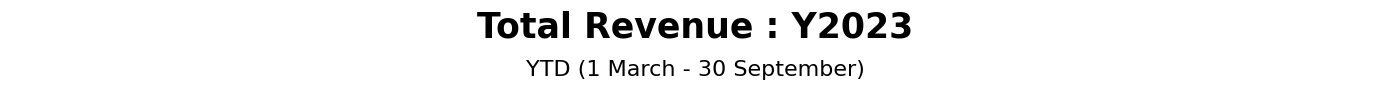

In [125]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Total Revenue : Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"YTD (1 March - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

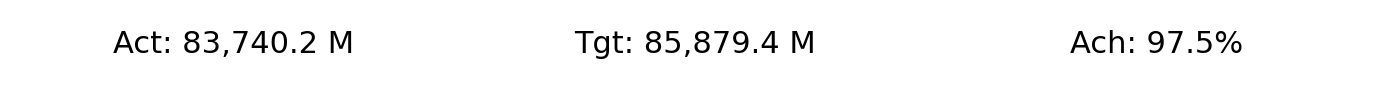

In [126]:
''' YTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
# ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(ytd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(ytd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

# ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=22, ha='center', va='center')
# ax4.spines[['top','left','right','bottom']].set_visible(False)
# ax4.set_axis_off()

fig.tight_layout()
plt.show()

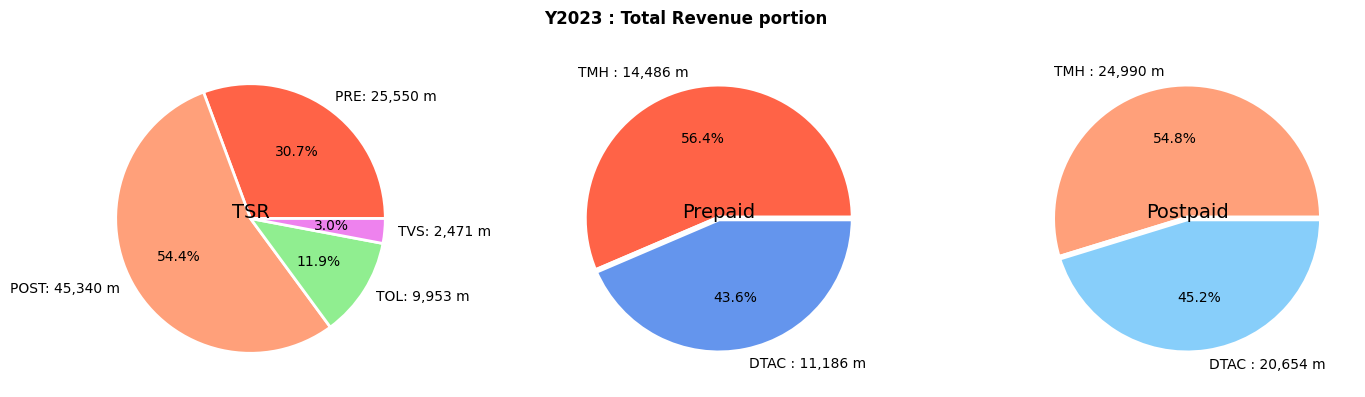

In [127]:
''' Revenue Portion Chart '''

fig = plt.figure(figsize=(14.3, 4))
fig.suptitle(f'Y{curr_yr} : Total Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])

''' ax1 '''
y = np.array([y_yr_act_pre.sum(), y_yr_act_post.sum(), y_yr_act_tol.sum(), y_yr_act_tvs.sum()])
mylabels = [f"PRE: {format(y[0],',.0f')} m", f"POST: {format(y[1],',.0f')} m", f"TOL: {format(y[2],',.0f')} m", f"TVS: {format(y[3],',.0f')} m"]
mycolors = ["tomato", "lightsalmon", "lightgreen", "violet",  "mediumpurple"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 2, "edgecolor": "white"})
ax1.text(0, 0, 'TSR', ha='center', fontsize=14)

''' ax2 '''
y = np.array([y_yr_act_pre_tmh.sum(), y_yr_act_pre_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} m", f"DTAC : {format(y[1],',.0f')} m"]
mycolors = ["tomato", "cornflowerblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'Prepaid', ha='center', fontsize=14)

''' ax3 '''
y = np.array([y_yr_act_post_tmh.sum(), y_yr_act_post_dtac.sum()])
mylabels = [f"TMH : {format(y[0],',.0f')} m", f"DTAC : {format(y[1],',.0f')} m"]
mycolors = ["lightsalmon", "lightskyblue"]
ax3.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax3.text(0, 0, 'Postpaid', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

## ** Monthly **

### MTH : Aggregation

In [128]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_rev_mth['%ACHV'] = df_rev_mth['ACT_SNAP'] / df_rev_mth['TGT_SNAP']
df_rev_mth['GAP'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['TGT_SNAP']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACT_SNAP'] / df_rev_mth['LAST_ACT']) - 1

df_rev_mth.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%MOM
51,TB4R000100,TVS Revenue (Geo),202305,May,S,360.683327,413.616346,0.872024,-52.933019,361.558440,-0.875113,-0.002420
52,TB4R000100,TVS Revenue (Geo),202306,June,S,355.369063,413.616346,0.859176,-58.247282,360.683327,-5.314263,-0.014734
53,TB4R000100,TVS Revenue (Geo),202307,July,S,388.791577,398.000000,0.976863,-9.208423,355.369063,33.422513,0.094050
54,TB4R000100,TVS Revenue (Geo),202308,August,S,388.599162,398.000000,0.976380,-9.400838,388.791577,-0.192415,-0.000495
55,TB4R000100,TVS Revenue (Geo),202309,September,S,236.939136,398.000000,0.595324,-161.060864,388.599162,-151.660026,-0.390274


In [129]:
''' Pivot by KPIS '''

df_rev_mth_agg = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_rev_mth_agg.tail(3)

TM_KEY_MTH   MTH_DESC     ACT_SNAP                            \
METRIC_NAME                               POST    POST_DTAC     POST_TMH   
4               202307       July  6451.450098  2940.214328  3511.235770   
5               202308     August  6486.256613  2930.632146  3555.624467   
6               202309  September  6117.856851  2940.006617  3481.783324   

                                                                             \
METRIC_NAME          PRE     PRE_DTAC      PRE_TMH          TOL         TVS   
4            3793.031946  1619.285724  2173.746222  1413.384874  388.791577   
5            3779.735208  1617.319830  2162.415378  1428.153072  388.599162   
6            3350.558221  1586.527314  1886.142520  1420.690160  236.939136   

             ...       DIFF                  %MOM                      \
METRIC_NAME  ...        TOL         TVS      POST POST_DTAC  POST_TMH   
4            ... -16.573994   33.422513  0.001024 -0.001805  0.003405   
5            ...  14.768198   -0.192415  0.005395 -0.003259  0.012642   
6            ...  -7.462913 -151.660026 -0.056797  0.003199 -0.020767   

                                                               
METRIC_NAME       PRE  PRE_DTAC   PRE_TMH       TOL       TVS  
4            0.042384  0.036339  0.046932 -0.011591  0.094050  
5           -0.003506 -0.001214 -0.005213  0.010449 -0.000495  
6           -0.113547 -0.019039 -0.127761 -0.005226 -0.390274  

[3 rows x 58 columns]

In [130]:
''' Add column for BG Summary '''

df_rev_mth_agg['ACT_BG'] = df_rev_mth_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['TGT_BG'] = df_rev_mth_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['%ACHV_BG'] = df_rev_mth_agg['ACT_BG'] / df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['GAP_BG'] = df_rev_mth_agg['ACT_BG'] - df_rev_mth_agg['TGT_BG']
df_rev_mth_agg['LAST_ACT_BG'] = df_rev_mth_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_mth_agg['DIFF_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, df_rev_mth_agg['ACT_BG']-df_rev_mth_agg['LAST_ACT_BG'])
df_rev_mth_agg['%MOM_BG'] = np.where(df_rev_mth_agg['LAST_ACT_BG']<=0, 0, (df_rev_mth_agg['ACT_BG']/df_rev_mth_agg['LAST_ACT_BG'])-1)

df_rev_mth_agg.tail(3)

TM_KEY_MTH   MTH_DESC     ACT_SNAP                            \
METRIC_NAME                               POST    POST_DTAC     POST_TMH   
4               202307       July  6451.450098  2940.214328  3511.235770   
5               202308     August  6486.256613  2930.632146  3555.624467   
6               202309  September  6117.856851  2940.006617  3481.783324   

                                                                             \
METRIC_NAME          PRE     PRE_DTAC      PRE_TMH          TOL         TVS   
4            3793.031946  1619.285724  2173.746222  1413.384874  388.791577   
5            3779.735208  1617.319830  2162.415378  1428.153072  388.599162   
6            3350.558221  1586.527314  1886.142520  1420.690160  236.939136   

             ...      %MOM                            ACT_BG        TGT_BG  \
METRIC_NAME  ...   PRE_TMH       TOL       TVS                               
4            ...  0.046932 -0.011591  0.094050  12046.658495  12364.856199   
5            ... -0.005213  0.010449 -0.000495  12082.744055  12390.038982   
6            ... -0.127761 -0.005226 -0.390274  11552.089070  12154.593788   

             %ACHV_BG      GAP_BG   LAST_ACT_BG     DIFF_BG   %MOM_BG  
METRIC_NAME                                                            
4            0.974266 -318.197704  11868.985678  177.672816  0.014970  
5            0.975198 -307.294927  12046.658495   36.085560  0.002995  
6            0.950430 -602.504717  12082.744055 -530.654984 -0.043918  

[3 rows x 65 columns]

In [131]:
''' BG Month to Date Values '''

df_last_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_mth = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==curr_mth) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())
# mtd_last_act_tmp = df_last_mth.head(day_cnt_curr_mth)['ACT_BG'].sum()
mtd_last_act = (df_last_mth['ACT_BG'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['ACT_BG'].sum()
mtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TGT_BG'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

In [132]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' Actual '''
y_mth_act = df_rev_mth_agg['ACT_BG']
y_mth_act_post = df_rev_mth_agg['ACT_SNAP']['POST']
y_mth_act_post_dtac = df_rev_mth_agg['ACT_SNAP']['POST_DTAC']
y_mth_act_post_tmh = df_rev_mth_agg['ACT_SNAP']['POST_TMH']
y_mth_act_pre = df_rev_mth_agg['ACT_SNAP']['PRE']
y_mth_act_pre_dtac = df_rev_mth_agg['ACT_SNAP']['PRE_DTAC']
y_mth_act_pre_tmh = df_rev_mth_agg['ACT_SNAP']['PRE_TMH']
y_mth_act_tol = df_rev_mth_agg['ACT_SNAP']['TOL']
y_mth_act_tvs = df_rev_mth_agg['ACT_SNAP']['TVS']

''' Target '''
y_mth_tgt = df_rev_mth_agg['TGT_BG']
y_mth_tgt_post = df_rev_mth_agg['TGT_SNAP']['POST']
y_mth_tgt_post_dtac = df_rev_mth_agg['TGT_SNAP']['POST_DTAC']
y_mth_tgt_post_tmh = df_rev_mth_agg['TGT_SNAP']['POST_TMH']
y_mth_tgt_pre = df_rev_mth_agg['TGT_SNAP']['PRE']
y_mth_tgt_pre_dtac = df_rev_mth_agg['TGT_SNAP']['PRE_DTAC']
y_mth_tgt_pre_tmh = df_rev_mth_agg['TGT_SNAP']['PRE_TMH']
y_mth_tgt_tol = df_rev_mth_agg['TGT_SNAP']['TOL']
y_mth_tgt_tvs = df_rev_mth_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_mth_achv = df_rev_mth_agg['%ACHV_BG']
y_mth_achv_post = df_rev_mth_agg['%ACHV']['POST']
y_mth_achv_post_dtac = df_rev_mth_agg['%ACHV']['POST_DTAC']
y_mth_achv_post_tmh = df_rev_mth_agg['%ACHV']['POST_TMH']
y_mth_achv_pre = df_rev_mth_agg['%ACHV']['PRE']
y_mth_achv_pre_dtac = df_rev_mth_agg['%ACHV']['PRE_DTAC']
y_mth_achv_pre_tmh = df_rev_mth_agg['%ACHV']['PRE_TMH']
y_mth_achv_tol = df_rev_mth_agg['%ACHV']['TOL']
y_mth_achv_tvs = df_rev_mth_agg['%ACHV']['TVS']

''' Gap '''
y_mth_gap = df_rev_mth_agg['GAP_BG']
y_mth_gap_post = df_rev_mth_agg['GAP']['POST']
y_mth_gap_post_dtac = df_rev_mth_agg['GAP']['POST_DTAC']
y_mth_gap_post_tmh = df_rev_mth_agg['GAP']['POST_TMH']
y_mth_gap_pre = df_rev_mth_agg['GAP']['PRE']
y_mth_gap_pre_dtac = df_rev_mth_agg['GAP']['PRE_DTAC']
y_mth_gap_pre_tmh = df_rev_mth_agg['GAP']['PRE_TMH']
y_mth_gap_tol = df_rev_mth_agg['GAP']['TOL']
y_mth_gap_tvs = df_rev_mth_agg['GAP']['TVS']

''' Last Actual '''
y_mth_last_act = df_rev_mth_agg['LAST_ACT_BG']
y_mth_last_act_post = df_rev_mth_agg['LAST_ACT']['POST']
y_mth_last_act_post_dtac = df_rev_mth_agg['LAST_ACT']['POST_DTAC']
y_mth_last_act_post_tmh = df_rev_mth_agg['LAST_ACT']['POST_TMH']
y_mth_last_act_pre = df_rev_mth_agg['LAST_ACT']['PRE']
y_mth_last_act_pre_dtac = df_rev_mth_agg['LAST_ACT']['PRE_DTAC']
y_mth_last_act_pre_tmh = df_rev_mth_agg['LAST_ACT']['PRE_TMH']
y_mth_last_act_tol = df_rev_mth_agg['LAST_ACT']['TOL']
y_mth_last_act_tvs = df_rev_mth_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_mth_diff = df_rev_mth_agg['DIFF_BG']
y_mth_diff_post = df_rev_mth_agg['DIFF']['POST']
y_mth_diff_post_dtac = df_rev_mth_agg['DIFF']['POST_DTAC']
y_mth_diff_post_tmh = df_rev_mth_agg['DIFF']['POST_TMH']
y_mth_diff_pre = df_rev_mth_agg['DIFF']['PRE']
y_mth_diff_pre_dtac = df_rev_mth_agg['DIFF']['PRE_DTAC']
y_mth_diff_pre_tmh = df_rev_mth_agg['DIFF']['PRE_TMH']
y_mth_diff_tol = df_rev_mth_agg['DIFF']['TOL']
y_mth_diff_tvs = df_rev_mth_agg['DIFF']['TVS']

''' % MOM '''
y_mth_mom = df_rev_mth_agg['%MOM_BG']
y_mth_mom_post = df_rev_mth_agg['%MOM']['POST']
y_mth_mom_post_dtac = df_rev_mth_agg['%MOM']['POST_DTAC']
y_mth_mom_post_tmh = df_rev_mth_agg['%MOM']['POST_TMH']
y_mth_mom_pre = df_rev_mth_agg['%MOM']['PRE']
y_mth_mom_pre_dtac = df_rev_mth_agg['%MOM']['PRE_DTAC']
y_mth_mom_pre_tmh = df_rev_mth_agg['%MOM']['PRE_TMH']
y_mth_mom_tol = df_rev_mth_agg['%MOM']['TOL']
y_mth_mom_tvs = df_rev_mth_agg['%MOM']['TVS']

### MTH : Visualizations

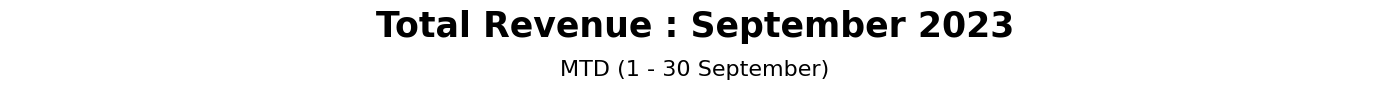

In [133]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Total Revenue : {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"MTD (1 - {curr_day_label} {curr_mth_desc})", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

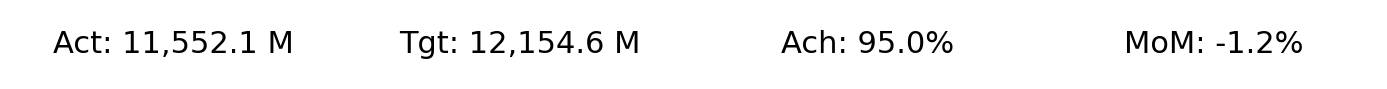

In [134]:
''' MTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(mtd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

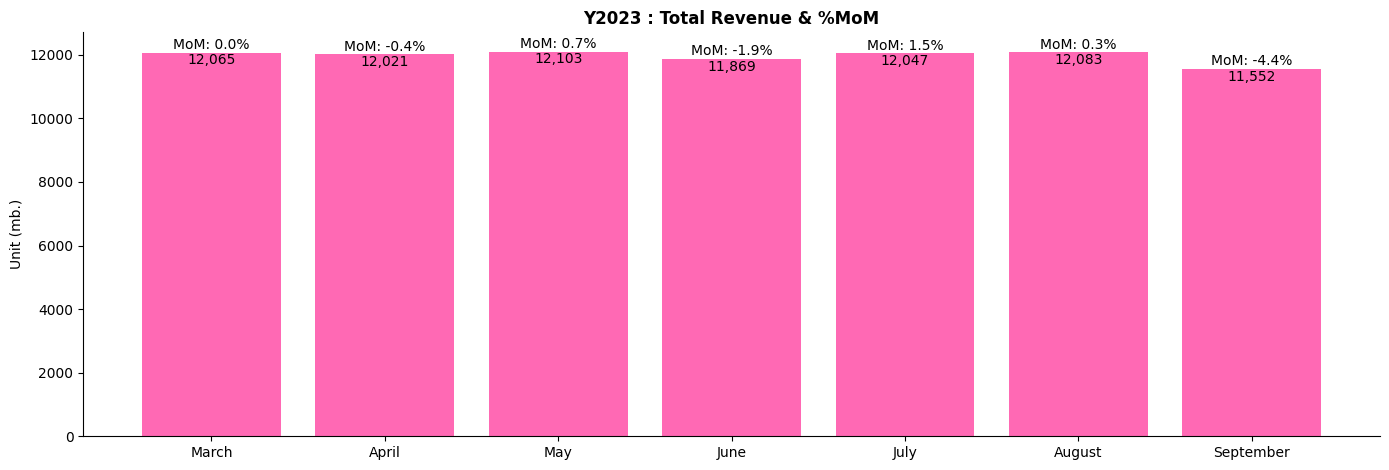

In [135]:
''' Total Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, y_mth_act, label='Total', color='hotpink')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-20), ha='center', va='top')

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
# plt.legend()
plt.tight_layout()
plt.show()

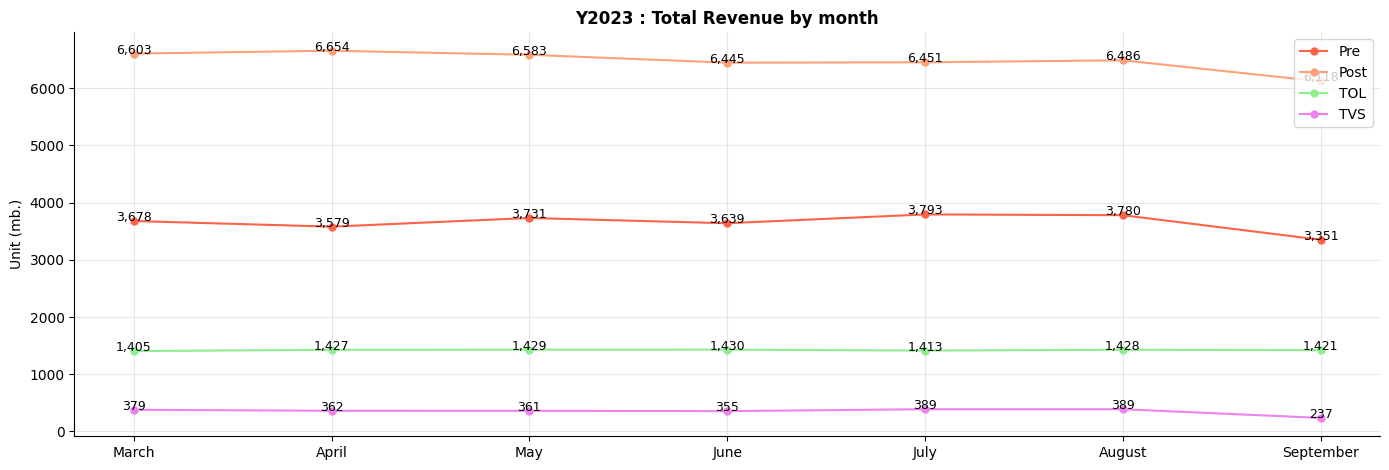

In [136]:
''' Revenue : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by month", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_mth_axis, y_mth_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_post[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

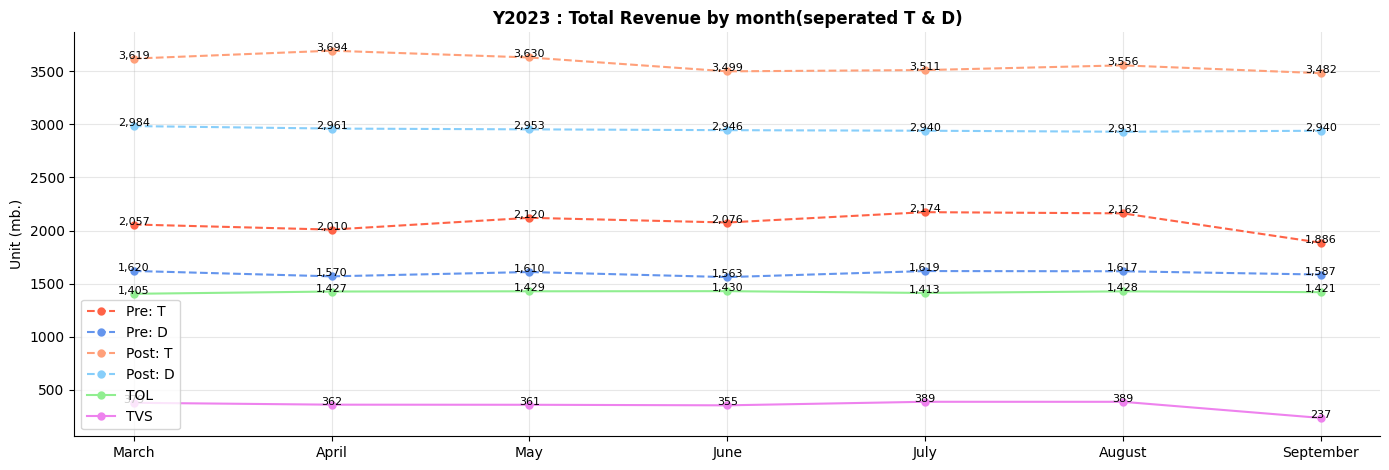

In [137]:
''' Revenue(Mobile separated by TMH, DTAC) : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by month(seperated T & D)", weight='bold')
plt.plot(x_mth_axis, y_mth_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_mth_axis, y_mth_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_mth_axis, y_mth_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_mth_axis, y_mth_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_mth_axis, y_mth_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_mth_axis, y_mth_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
for i in x_mth_axis:
    plt.annotate(format(y_mth_act_pre_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_pre_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_post_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tol[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_mth_act_tvs[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tvs[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Weekly **

### WK : Aggregation

In [138]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

# ''' Aggregation '''
df_rev_wk['%ACHV'] = df_rev_wk['ACT_SNAP'] / df_rev_wk['TGT_SNAP']
df_rev_wk['GAP'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['TGT_SNAP']
df_rev_wk['LAST_ACT'] = df_rev_wk.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_wk['DIFF'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['LAST_ACT']
df_rev_wk['%WOW'] = (df_rev_wk['ACT_SNAP'] / df_rev_wk['LAST_ACT']) - 1

df_rev_wk.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_WK,WK_LABEL,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%WOW
245,TB4R000100,TVS Revenue (Geo),2023037,37,S,52.202362,60.089321,0.868746,-7.886960,47.779005,4.423357,0.092580
246,TB4R000100,TVS Revenue (Geo),2023038,38,S,47.964051,54.829627,0.874783,-6.865575,52.202362,-4.238310,-0.081190
247,TB4R000100,TVS Revenue (Geo),2023039,39,S,46.090955,186.077736,0.247697,-139.986781,47.964051,-1.873096,-0.039052


In [139]:
''' Pivot by KPIS '''

df_rev_wk_agg = df_rev_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL     ACT_SNAP                          \
METRIC_NAME                            POST   POST_DTAC    POST_TMH   
28            2023037       37  1380.870440  615.208986  765.661454   
29            2023038       38  1327.863012  623.749327  704.113685   
30            2023039       39  1077.112877  681.013609  700.032357   

                                                                        ...  \
METRIC_NAME         PRE    PRE_DTAC     PRE_TMH         TOL        TVS  ...   
28           810.440210  351.549406  458.890804  315.419390  52.202362  ...   
29           818.543297  360.310377  458.232920  314.348852  47.964051  ...   
30           466.088903  332.637069  255.563447  276.144968  46.090955  ...   

                  DIFF                %WOW                                \
METRIC_NAME        TOL       TVS      POST POST_DTAC  POST_TMH       PRE   
28           -1.533156  4.423357  0.001902 -0.079296  0.078313 -0.043178   
29           -1.070538 -4.238310 -0.038387  0.013882 -0.080385  0.009998   
30          -38.203885 -1.873096 -0.188837  0.091807 -0.005796 -0.430587   

                                                     
METRIC_NAME  PRE_DTAC   PRE_TMH       TOL       TVS  
28          -0.039549 -0.045940 -0.004837  0.092580  
29           0.024921 -0.001434 -0.003394 -0.081190  
30          -0.076804 -0.442285 -0.121533 -0.039052  

[3 rows x 58 columns]

In [140]:
''' Add column for BG Summary '''

df_rev_wk_agg['ACT_BG'] = df_rev_wk_agg['ACT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['TGT_BG'] = df_rev_wk_agg['TGT_SNAP'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['%ACHV_BG'] = df_rev_wk_agg['ACT_BG'] / df_rev_wk_agg['TGT_BG']
df_rev_wk_agg['GAP_BG'] = df_rev_wk_agg['ACT_BG'] - df_rev_wk_agg['TGT_BG']
df_rev_wk_agg['LAST_ACT_BG'] = df_rev_wk_agg['LAST_ACT'][list(bg_col_list)].sum(axis=1)
df_rev_wk_agg['DIFF_BG'] = np.where(df_rev_wk_agg['LAST_ACT_BG']<=0, 0, df_rev_wk_agg['ACT_BG']-df_rev_wk_agg['LAST_ACT_BG'])
df_rev_wk_agg['%WOW_BG'] = np.where(df_rev_wk_agg['LAST_ACT_BG']<=0, 0, (df_rev_wk_agg['ACT_BG']/df_rev_wk_agg['LAST_ACT_BG'])-1)

df_rev_wk_agg.tail(3)

TM_KEY_WK WK_LABEL     ACT_SNAP                          \
METRIC_NAME                            POST   POST_DTAC    POST_TMH   
28            2023037       37  1380.870440  615.208986  765.661454   
29            2023038       38  1327.863012  623.749327  704.113685   
30            2023039       39  1077.112877  681.013609  700.032357   

                                                                        ...  \
METRIC_NAME         PRE    PRE_DTAC     PRE_TMH         TOL        TVS  ...   
28           810.440210  351.549406  458.890804  315.419390  52.202362  ...   
29           818.543297  360.310377  458.232920  314.348852  47.964051  ...   
30           466.088903  332.637069  255.563447  276.144968  46.090955  ...   

                 %WOW                           ACT_BG       TGT_BG  %ACHV_BG  \
METRIC_NAME   PRE_TMH       TOL       TVS                                       
28          -0.045940 -0.004837  0.092580  2558.932401  2678.020154  0.955531   
29          -0.001434 -0.003394 -0.081190  2508.719212  2593.673211  0.967246   
30          -0.442285 -0.121533 -0.039052  2291.482406  2586.339240  0.885995   

                 GAP_BG  LAST_ACT_BG     DIFF_BG   %WOW_BG  
METRIC_NAME                                                 
28          -119.087753  2589.993522  -31.061121 -0.011993  
29           -84.953998  2558.932401  -50.213189 -0.019623  
30          -294.856835  2508.719212 -217.236807 -0.086593  

[3 rows x 65 columns]

In [141]:
''' BG Week to Date Values '''

df_last_wk = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==last_wk][['TM_KEY_DAY', 'TM_KEY_WK', 'ACT_BG', 'TGT_BG']].reset_index()
day_cnt_curr_wk = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_WK']==curr_wk) & (df_rev_day_agg['ACT_BG']>0)]['TM_KEY_DAY'].unique())

# wtd_last_act_tmp = df_last_wk.head(day_cnt_curr_wk)['ACT_BG'].sum()
wtd_last_act = (df_last_wk['ACT_BG'].sum() / len(df_last_wk['TM_KEY_DAY'].unique())) * day_cnt_curr_wk
wtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['ACT_BG'].sum()
wtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TGT_BG'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

In [142]:
''' Week Chart Values '''

x_wk = df_rev_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' Actual '''
y_wk_act = df_rev_wk_agg['ACT_BG']
y_wk_act_post = df_rev_wk_agg['ACT_SNAP']['POST']
y_wk_act_post_dtac = df_rev_wk_agg['ACT_SNAP']['POST_DTAC']
y_wk_act_post_tmh = df_rev_wk_agg['ACT_SNAP']['POST_TMH']
y_wk_act_pre = df_rev_wk_agg['ACT_SNAP']['PRE']
y_wk_act_pre_dtac = df_rev_wk_agg['ACT_SNAP']['PRE_DTAC']
y_wk_act_pre_tmh = df_rev_wk_agg['ACT_SNAP']['PRE_TMH']
y_wk_act_tol = df_rev_wk_agg['ACT_SNAP']['TOL']
y_wk_act_tvs = df_rev_wk_agg['ACT_SNAP']['TVS']

''' Target '''
y_wk_tgt = df_rev_wk_agg['TGT_BG']
y_wk_tgt_post = df_rev_wk_agg['TGT_SNAP']['POST']
y_wk_tgt_post_dtac = df_rev_wk_agg['TGT_SNAP']['POST_DTAC']
y_wk_tgt_post_tmh = df_rev_wk_agg['TGT_SNAP']['POST_TMH']
y_wk_tgt_pre = df_rev_wk_agg['TGT_SNAP']['PRE']
y_wk_tgt_pre_dtac = df_rev_wk_agg['TGT_SNAP']['PRE_DTAC']
y_wk_tgt_pre_tmh = df_rev_wk_agg['TGT_SNAP']['PRE_TMH']
y_wk_tgt_tol = df_rev_wk_agg['TGT_SNAP']['TOL']
y_wk_tgt_tvs = df_rev_wk_agg['TGT_SNAP']['TVS']

''' % Achievement '''
y_wk_achv = df_rev_wk_agg['%ACHV_BG']
y_wk_achv_post = df_rev_wk_agg['%ACHV']['POST']
y_wk_achv_post_dtac = df_rev_wk_agg['%ACHV']['POST_DTAC']
y_wk_achv_post_tmh = df_rev_wk_agg['%ACHV']['POST_TMH']
y_wk_achv_pre = df_rev_wk_agg['%ACHV']['PRE']
y_wk_achv_pre_dtac = df_rev_wk_agg['%ACHV']['PRE_DTAC']
y_wk_achv_pre_tmh = df_rev_wk_agg['%ACHV']['PRE_TMH']
y_wk_achv_tol = df_rev_wk_agg['%ACHV']['TOL']
y_wk_achv_tvs = df_rev_wk_agg['%ACHV']['TVS']

''' Gap '''
y_wk_gap = df_rev_wk_agg['GAP_BG']
y_wk_gap_post = df_rev_wk_agg['GAP']['POST']
y_wk_gap_post_dtac = df_rev_wk_agg['GAP']['POST_DTAC']
y_wk_gap_post_tmh = df_rev_wk_agg['GAP']['POST_TMH']
y_wk_gap_pre = df_rev_wk_agg['GAP']['PRE']
y_wk_gap_pre_dtac = df_rev_wk_agg['GAP']['PRE_DTAC']
y_wk_gap_pre_tmh = df_rev_wk_agg['GAP']['PRE_TMH']
y_wk_gap_tol = df_rev_wk_agg['GAP']['TOL']
y_wk_gap_tvs = df_rev_wk_agg['GAP']['TVS']

''' Last Actual '''
y_wk_last_act = df_rev_wk_agg['LAST_ACT_BG']
y_wk_last_act_post = df_rev_wk_agg['LAST_ACT']['POST']
y_wk_last_act_post_dtac = df_rev_wk_agg['LAST_ACT']['POST_DTAC']
y_wk_last_act_post_tmh = df_rev_wk_agg['LAST_ACT']['POST_TMH']
y_wk_last_act_pre = df_rev_wk_agg['LAST_ACT']['PRE']
y_wk_last_act_pre_dtac = df_rev_wk_agg['LAST_ACT']['PRE_DTAC']
y_wk_last_act_pre_tmh = df_rev_wk_agg['LAST_ACT']['PRE_TMH']
y_wk_last_act_tol = df_rev_wk_agg['LAST_ACT']['TOL']
y_wk_last_act_tvs = df_rev_wk_agg['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_wk_diff = df_rev_wk_agg['DIFF_BG']
y_wk_diff_post = df_rev_wk_agg['DIFF']['POST']
y_wk_diff_post_dtac = df_rev_wk_agg['DIFF']['POST_DTAC']
y_wk_diff_post_tmh = df_rev_wk_agg['DIFF']['POST_TMH']
y_wk_diff_pre = df_rev_wk_agg['DIFF']['PRE']
y_wk_diff_pre_dtac = df_rev_wk_agg['DIFF']['PRE_DTAC']
y_wk_diff_pre_tmh = df_rev_wk_agg['DIFF']['PRE_TMH']
y_wk_diff_tol = df_rev_wk_agg['DIFF']['TOL']
y_wk_diff_tvs = df_rev_wk_agg['DIFF']['TVS']

''' % WOW '''
y_wk_wow = df_rev_wk_agg['%WOW_BG']
y_wk_wow_post = df_rev_wk_agg['%WOW']['POST']
y_wk_wow_post_dtac = df_rev_wk_agg['%WOW']['POST_DTAC']
y_wk_wow_post_tmh = df_rev_wk_agg['%WOW']['POST_TMH']
y_wk_wow_pre = df_rev_wk_agg['%WOW']['PRE']
y_wk_wow_pre_dtac = df_rev_wk_agg['%WOW']['PRE_DTAC']
y_wk_wow_pre_tmh = df_rev_wk_agg['%WOW']['PRE_TMH']
y_wk_wow_tol = df_rev_wk_agg['%WOW']['TOL']
y_wk_wow_tvs = df_rev_wk_agg['%WOW']['TVS']

### WK : Visualizations

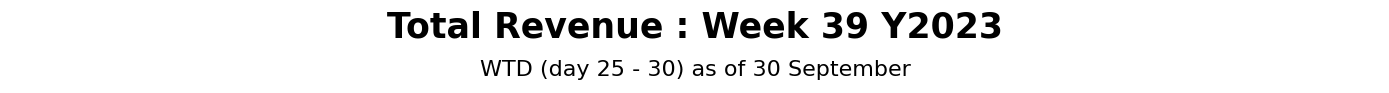

In [143]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(2, 1)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"Total Revenue : Week {curr_wk_label} Y{curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"WTD (day {wk_day_start} - {wk_day_end}) as of {curr_day_label} {curr_mth_desc}", size=16, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

fig.tight_layout()
plt.show()

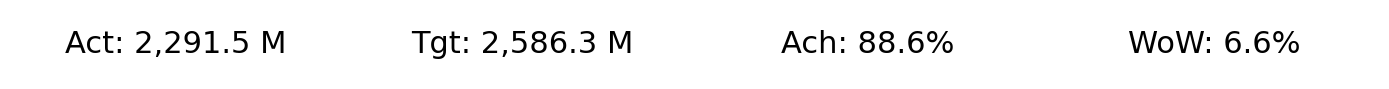

In [144]:
''' WTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(wtd_act,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(wtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

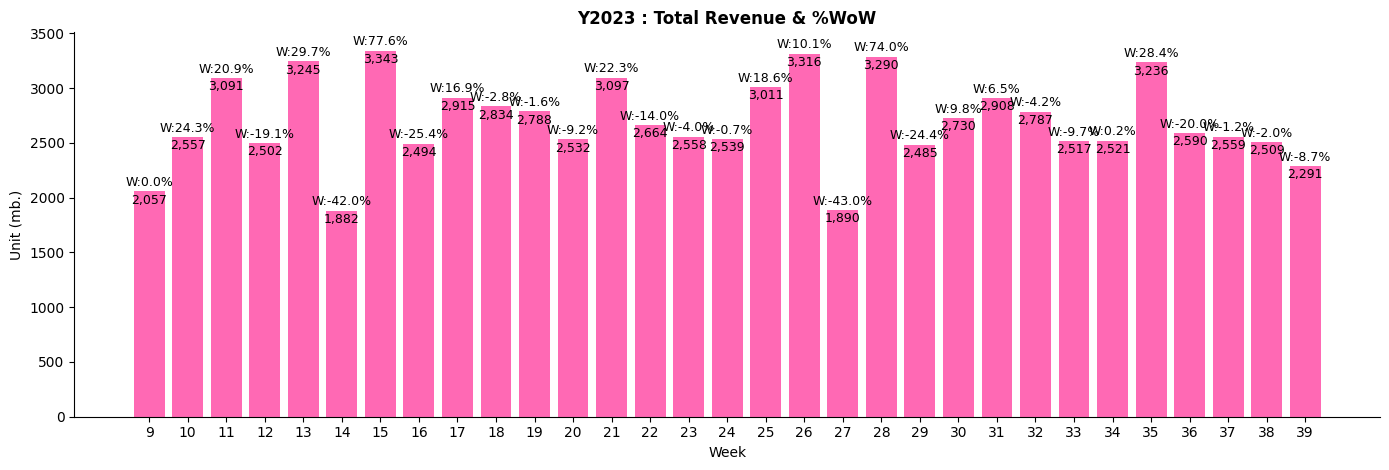

In [145]:
''' Total Revenue & WoW : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue & %WoW", weight='bold')
plt.bar(x_wk_axis, y_wk_act, label='Total', color='hotpink')
for i in x_wk_axis:
    plt.annotate(f"W:{format(y_wk_wow[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]-20), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.tight_layout()
plt.show()

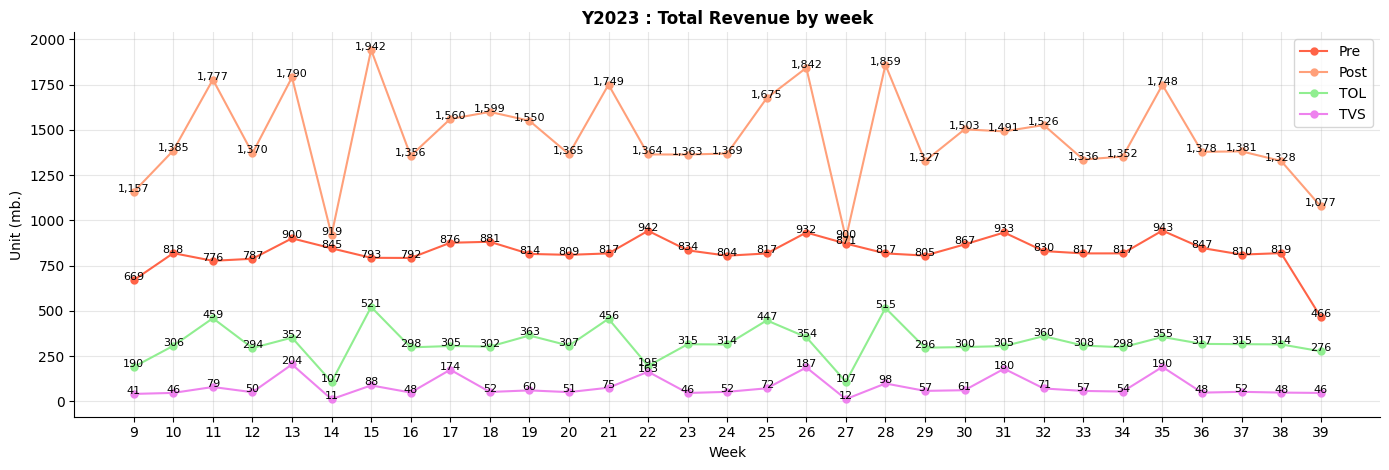

In [146]:
''' Revenue : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by week", weight='bold')
plt.plot(x_wk_axis, y_wk_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_wk_axis, y_wk_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_wk_axis, y_wk_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_wk_axis, y_wk_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act_pre[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tol[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tvs[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tvs[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

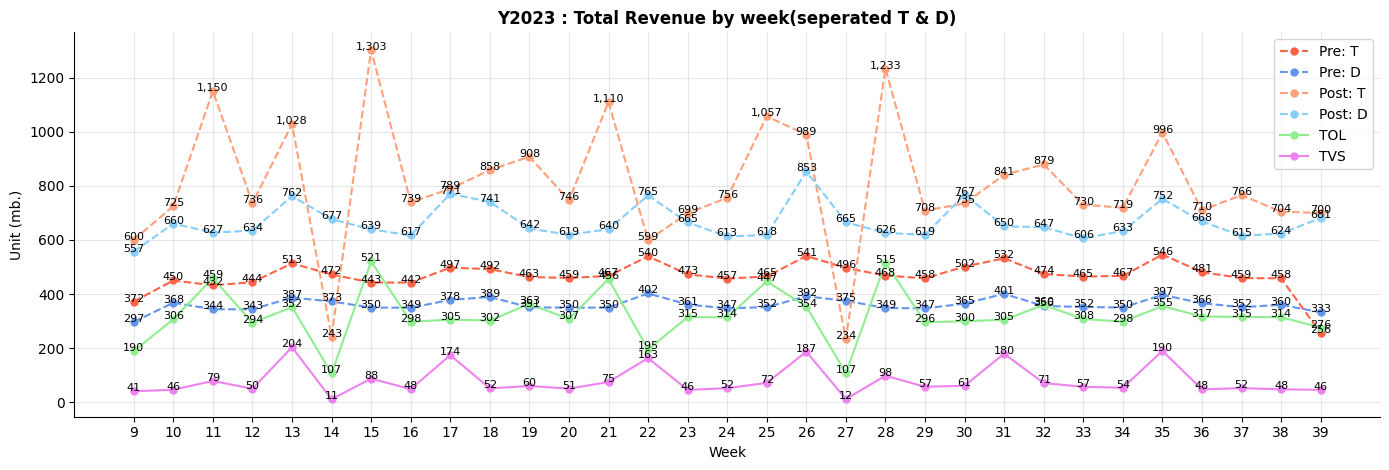

In [147]:
''' Revenue(Mobile separated by TMH, DTAC) : WK Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : Total Revenue by week(seperated T & D)", weight='bold')
plt.plot(x_wk_axis, y_wk_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_wk_axis, y_wk_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_wk_axis, y_wk_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_wk_axis, y_wk_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_wk_axis, y_wk_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_wk_axis, y_wk_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act_pre_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_pre_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_post_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tol[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_wk_act_tvs[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tvs[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel('Week')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## ** Daily (MTD) **

### DAY : Aggregation

In [148]:
''' Create Dataframe '''

df_rev_day_curr_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth].reset_index()

df_rev_day_curr_mth_clean = df_rev_day_curr_mth[df_rev_day_curr_mth['ACT_BG'] > 0].reset_index()

df_rev_day_curr_day = df_rev_day_curr_mth_clean.loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

df_rev_day_last_day = df_rev_day_curr_mth_clean.shift().loc[df_rev_day_curr_mth_clean.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax()]

In [149]:
''' DTD Values '''

''' Last Period : Values '''
last_day_rev = df_rev_day_last_day['ACT_BG'].sum()

''' TOTAL : Values '''
dtd_rev = df_rev_day_curr_day['ACT_BG'].sum()
dtd_tgt = df_rev_day_curr_day['TGT_BG'].sum()
dtd_achv = dtd_rev / dtd_tgt
dtd_last_rev = df_rev_day_last_day['ACT_BG'].sum()
dtd_dod = (dtd_rev / dtd_last_rev) - 1
dtd_gap = dtd_rev - dtd_last_rev

In [150]:
''' Day Chart Values '''

x_day = df_rev_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' Actual '''
y_day_act = df_rev_day_curr_mth['ACT_BG']
y_day_act_post = df_rev_day_curr_mth['ACT_SNAP']['POST']
y_day_act_post_dtac = df_rev_day_curr_mth['ACT_SNAP']['POST_DTAC']
y_day_act_post_tmh = df_rev_day_curr_mth['ACT_SNAP']['POST_TMH']
y_day_act_pre = df_rev_day_curr_mth['ACT_SNAP']['PRE']
y_day_act_pre_dtac = df_rev_day_curr_mth['ACT_SNAP']['PRE_DTAC']
y_day_act_pre_tmh = df_rev_day_curr_mth['ACT_SNAP']['PRE_TMH']
y_day_act_tol = df_rev_day_curr_mth['ACT_SNAP']['TOL']
y_day_act_tvs = df_rev_day_curr_mth['ACT_SNAP']['TVS']

''' Target '''
y_day_tgt = df_rev_day_curr_mth['TGT_BG']
y_day_tgt_post = df_rev_day_curr_mth['TGT_SNAP']['POST']
y_day_tgt_post_dtac = df_rev_day_curr_mth['TGT_SNAP']['POST_DTAC']
y_day_tgt_post_tmh = df_rev_day_curr_mth['TGT_SNAP']['POST_TMH']
y_day_tgt_pre = df_rev_day_curr_mth['TGT_SNAP']['PRE']
y_day_tgt_pre_dtac = df_rev_day_curr_mth['TGT_SNAP']['PRE_DTAC']
y_day_tgt_pre_tmh = df_rev_day_curr_mth['TGT_SNAP']['PRE_TMH']
y_day_tgt_tol = df_rev_day_curr_mth['TGT_SNAP']['TOL']
y_day_tgt_tvs = df_rev_day_curr_mth['TGT_SNAP']['TVS']

''' % Achievement '''
y_day_achv = df_rev_day_curr_mth['%ACHV_BG']
y_day_achv_post = df_rev_day_curr_mth['%ACHV']['POST']
y_day_achv_post_dtac = df_rev_day_curr_mth['%ACHV']['POST_DTAC']
y_day_achv_post_tmh = df_rev_day_curr_mth['%ACHV']['POST_TMH']
y_day_achv_pre = df_rev_day_curr_mth['%ACHV']['PRE']
y_day_achv_pre_dtac = df_rev_day_curr_mth['%ACHV']['PRE_DTAC']
y_day_achv_pre_tmh = df_rev_day_curr_mth['%ACHV']['PRE_TMH']
y_day_achv_tol = df_rev_day_curr_mth['%ACHV']['TOL']
y_day_achv_tvs = df_rev_day_curr_mth['%ACHV']['TVS']

''' Gap '''
y_day_gap = df_rev_day_curr_mth['GAP_BG']
y_day_gap_post = df_rev_day_curr_mth['GAP']['POST']
y_day_gap_post_dtac = df_rev_day_curr_mth['GAP']['POST_DTAC']
y_day_gap_post_tmh = df_rev_day_curr_mth['GAP']['POST_TMH']
y_day_gap_pre = df_rev_day_curr_mth['GAP']['PRE']
y_day_gap_pre_dtac = df_rev_day_curr_mth['GAP']['PRE_DTAC']
y_day_gap_pre_tmh = df_rev_day_curr_mth['GAP']['PRE_TMH']
y_day_gap_tol = df_rev_day_curr_mth['GAP']['TOL']
y_day_gap_tvs = df_rev_day_curr_mth['GAP']['TVS']

''' Last Actual '''
y_day_last_act = df_rev_day_curr_mth['LAST_ACT_BG']
y_day_last_act_post = df_rev_day_curr_mth['LAST_ACT']['POST']
y_day_last_act_post_dtac = df_rev_day_curr_mth['LAST_ACT']['POST_DTAC']
y_day_last_act_post_tmh = df_rev_day_curr_mth['LAST_ACT']['POST_TMH']
y_day_last_act_pre = df_rev_day_curr_mth['LAST_ACT']['PRE']
y_day_last_act_pre_dtac = df_rev_day_curr_mth['LAST_ACT']['PRE_DTAC']
y_day_last_act_pre_tmh = df_rev_day_curr_mth['LAST_ACT']['PRE_TMH']
y_day_last_act_tol = df_rev_day_curr_mth['LAST_ACT']['TOL']
y_day_last_act_tvs = df_rev_day_curr_mth['LAST_ACT']['TVS']

''' Diff Last Actual '''
y_day_diff = df_rev_day_curr_mth['DIFF_BG']
y_day_diff_post = df_rev_day_curr_mth['DIFF']['POST']
y_day_diff_post_dtac = df_rev_day_curr_mth['DIFF']['POST_DTAC']
y_day_diff_post_tmh = df_rev_day_curr_mth['DIFF']['POST_TMH']
y_day_diff_pre = df_rev_day_curr_mth['DIFF']['PRE']
y_day_diff_pre_dtac = df_rev_day_curr_mth['DIFF']['PRE_DTAC']
y_day_diff_pre_tmh = df_rev_day_curr_mth['DIFF']['PRE_TMH']
y_day_diff_tol = df_rev_day_curr_mth['DIFF']['TOL']
y_day_diff_tvs = df_rev_day_curr_mth['DIFF']['TVS']

''' % DOD '''
y_day_dod = df_rev_day_curr_mth['%DOD_BG']
y_day_dod_post = df_rev_day_curr_mth['%DOD']['POST']
y_day_dod_post_dtac = df_rev_day_curr_mth['%DOD']['POST_DTAC']
y_day_dod_post_tmh = df_rev_day_curr_mth['%DOD']['POST_TMH']
y_day_dod_pre = df_rev_day_curr_mth['%DOD']['PRE']
y_day_dod_pre_dtac = df_rev_day_curr_mth['%DOD']['PRE_DTAC']
y_day_dod_pre_tmh = df_rev_day_curr_mth['%DOD']['PRE_TMH']
y_day_dod_tol = df_rev_day_curr_mth['%DOD']['TOL']
y_day_dod_tvs = df_rev_day_curr_mth['%DOD']['TVS']

### DAY : Visualizations

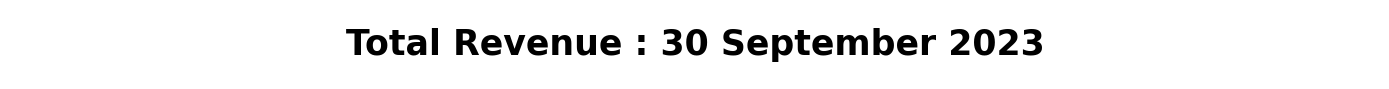

In [151]:

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[:, :])

ax1.text(0.5, 0.5, f"Total Revenue : {curr_day_label} {curr_mth_desc} {curr_yr}", size=25, ha='center', va='center', weight='bold')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

fig.tight_layout()
plt.show()

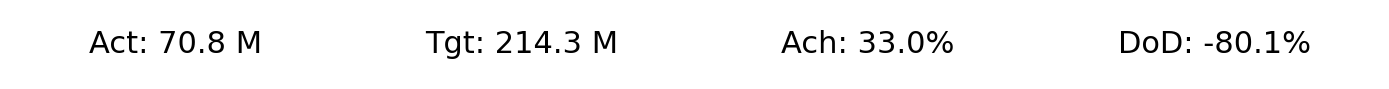

In [152]:
''' DTD Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(dtd_rev,',.1f')} M", size=22, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(dtd_tgt,',.1f')} M", size=22, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(dtd_achv,',.1%')}", size=22, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(dtd_dod,',.1%')}", size=22, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

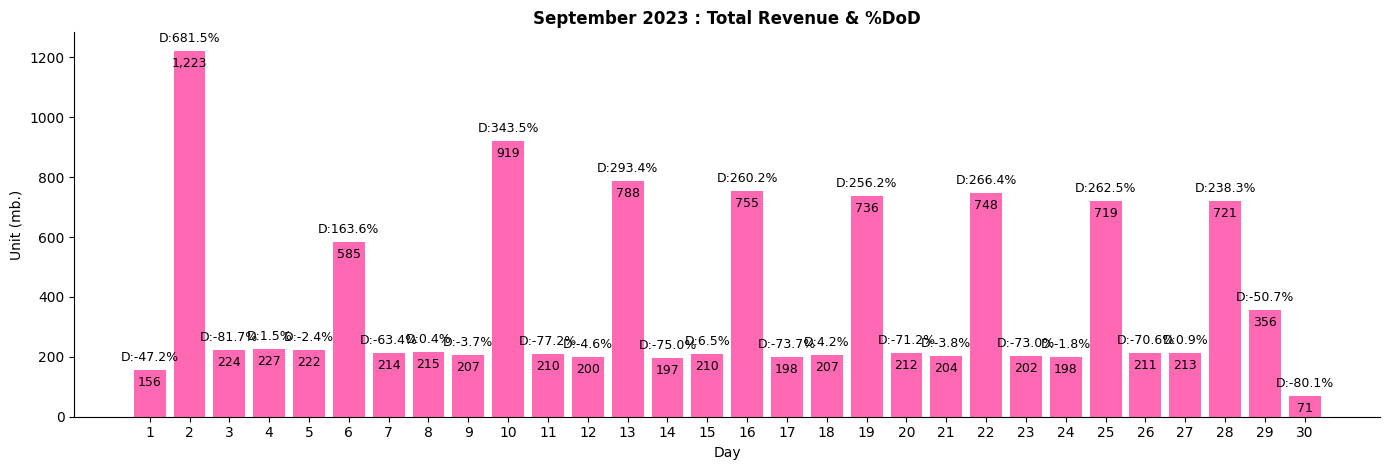

In [153]:
''' Total Revenue & DoD : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : Total Revenue & %DoD", fontdict={'fontweight': 'bold'})
plt.bar(x_day_axis, y_day_act, label='Total', color='hotpink')
for i in x_day_axis:
    plt.annotate(f"D:{format(y_day_dod[i],',.1%')}", xy=(x_day_axis[i], y_day_act[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]-20), ha='center', va='top', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day')
plt.xticks(x_day_axis, x_day)
plt.tight_layout()
plt.show()

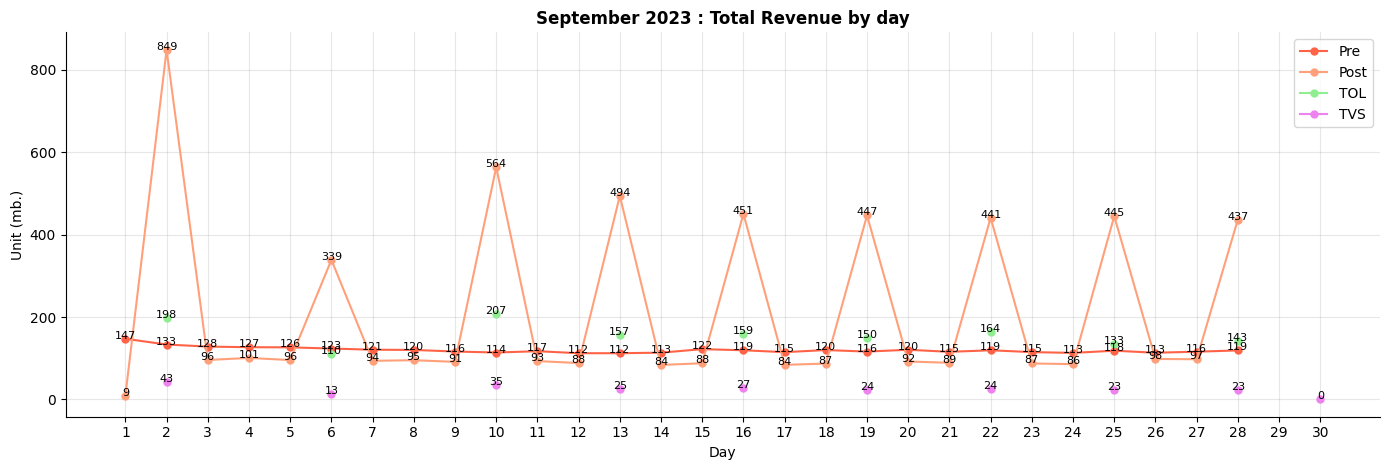

In [154]:
''' Revenue : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : Total Revenue by day", fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act_pre, marker='.', markeredgewidth=3, label='Pre', color='tomato')
plt.plot(x_day_axis, y_day_act_post, marker='.', markeredgewidth=3, label='Post', color='lightsalmon')
plt.plot(x_day_axis, y_day_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_day_axis, y_day_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
for i in x_day_axis:
    plt.annotate(format(y_day_act_pre[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post[i],',.0f'), xy=(x_day_axis[i], y_day_act_post[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tol[i],',.0f'), xy=(x_day_axis[i], y_day_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tvs[i],',.0f'), xy=(x_day_axis[i], y_day_act_tvs[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

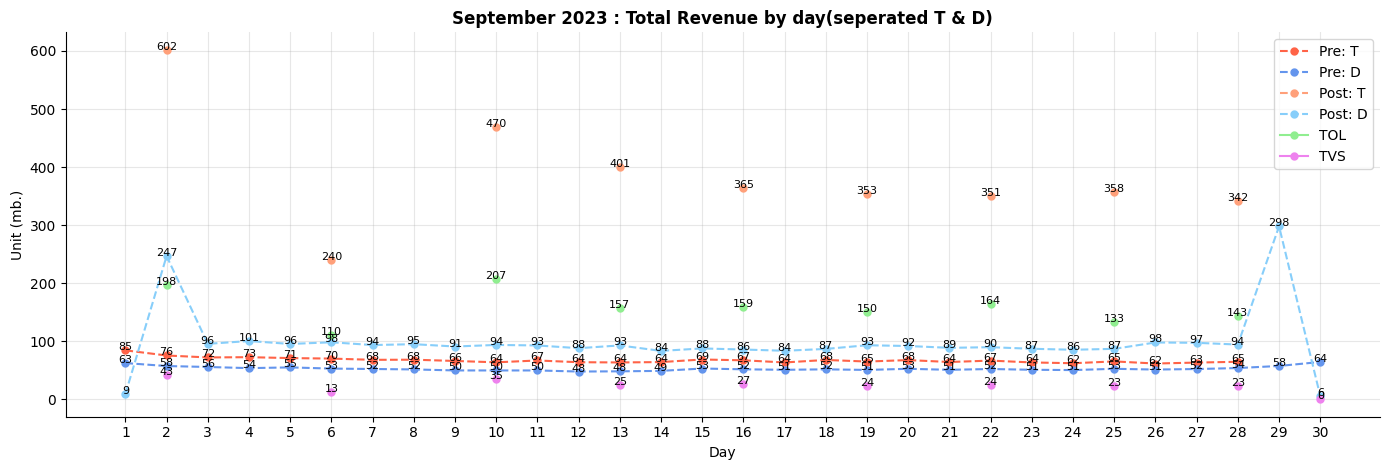

In [155]:
''' Revenue(Mobile separated by TMH, DTAC) : DAY Chart '''

plt.figure().set_figwidth(14)

plt.title(f"{curr_mth_desc} {curr_yr} : Total Revenue by day(seperated T & D)", fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act_pre_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: T', color='tomato')
plt.plot(x_day_axis, y_day_act_pre_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Pre: D', color='cornflowerblue')
plt.plot(x_day_axis, y_day_act_post_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: T', color='lightsalmon')
plt.plot(x_day_axis, y_day_act_post_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Post: D', color='lightskyblue')
plt.plot(x_day_axis, y_day_act_tol, marker='.', markeredgewidth=3, label='TOL', color='lightgreen')
plt.plot(x_day_axis, y_day_act_tvs, marker='.', markeredgewidth=3, label='TVS', color='violet')
for i in x_day_axis:
    plt.annotate(format(y_day_act_pre_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_pre_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_pre_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_post_tmh[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_post_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_post_dtac[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tol[i],',.0f'), xy=(x_day_axis[i], y_day_act_tol[i]), ha='center', fontsize=8)
    plt.annotate(format(y_day_act_tvs[i],',.0f'), xy=(x_day_axis[i], y_day_act_tvs[i]), ha='center', fontsize=8)

plt.ylabel('Unit (mb.)')
plt.xlabel(f'Day')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Generate Output Data

In [156]:
# df_rev_day.to_excel('../data/interim/df_rev_day.xlsx', index=False)
# df_rev_yr.to_excel('../data/interim/df_rev_yr.xlsx', index=False)
# df_rev_mth.to_excel('../data/interim/df_rev_mth.xlsx', index=False)
# df_rev_wk.to_excel('../data/interim/df_rev_wk.xlsx', index=False)